In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np

In [3]:
data=pd.read_csv("../../kaggle/ASHRAE/train.csv/train.csv")
weather_info=pd.read_csv("../../kaggle/ASHRAE/weather_train.csv/weather_train.csv")
building_metadata=pd.read_csv("../../kaggle/ASHRAE/building_metadata.csv")
data_merge=data.merge(building_metadata,how="left",on="building_id")
data_merge=data_merge.merge(weather_info,how="left",on=["timestamp","site_id"])

In [4]:
test_data=pd.read_csv("../../kaggle/ASHRAE/test.csv/test.csv")
weather_info_test=pd.read_csv("../../kaggle/ASHRAE/weather_test.csv/weather_test.csv")
test_data_merge=test_data.merge(building_metadata,how="left",on="building_id")
test_data_merge=test_data_merge.merge(weather_info_test,how="left",on=["timestamp","site_id"])

In [5]:
data["timestamp"]=pd.to_datetime(data["timestamp"])
test_data["timestamp"]=pd.to_datetime(test_data["timestamp"])
data_merge["timestamp"]=pd.to_datetime(data_merge["timestamp"])
test_data_merge["timestamp"]=pd.to_datetime(test_data_merge["timestamp"])
weather_info["timestamp"]=pd.to_datetime(weather_info["timestamp"])
weather_info_test["timestamp"]=pd.to_datetime(weather_info_test["timestamp"])

### こっちで天気データの欠損値の補間を行う
- #### 補間できない箇所が存在する
- #### site_id7,11にはcloud_coverageのデータ、site_id1,5,12にはprecip_depth_1_hr、site_id5にはsea_level_pressureのデータがまったく存在しない
- #### 学習データと検証データで同じsite_id

In [16]:
weather_info=weather_info.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
weather_info_test=weather_info_test.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))


In [17]:
weather_info.isna().sum()

site_id                   0
timestamp                 0
air_temperature           0
cloud_coverage        17228
dew_temperature           0
precip_depth_1_hr     26273
sea_level_pressure     8755
wind_direction            0
wind_speed                0
dtype: int64

In [18]:
weather_info.groupby('site_id').apply(lambda group: group.isna().sum())

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
site_id,,,,,,,,,
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,8763,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,8755,8755,0,0
6,0,0,0,0,0,0,0,0,0
7,0,0,0,8614,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0


In [21]:
weather_info_test.isna().sum()

site_id                   0
timestamp                 0
air_temperature           0
cloud_coverage        17228
dew_temperature           0
precip_depth_1_hr     26273
sea_level_pressure     8755
wind_direction            0
wind_speed                0
dtype: int64

In [22]:
weather_info_test.groupby('site_id').apply(lambda group: group.isna().sum())

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
site_id,,,,,,,,,
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,8763,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,8755,8755,0,0
6,0,0,0,0,0,0,0,0,0
7,0,0,0,8614,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0


### データ前処理のテクニックについて
- #### 天気データに関しては窓関数を適用,max,mean,min,std
- #### 窓は3時間のものと72時間のもの
- #### 天気に関連した変数が7つなので、4×7×2で56の状態量を作成

In [26]:
weather_info[weather_info["site_id"]==0]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,4.0,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6
...,...,...,...,...,...,...,...,...,...
8779,0,2016-12-31 19:00:00,22.8,4.0,10.0,0.0,1021.7,140.0,5.7
8780,0,2016-12-31 20:00:00,23.3,4.0,8.9,0.0,1021.0,170.0,4.1
8781,0,2016-12-31 21:00:00,23.3,4.0,10.0,0.0,1021.1,150.0,4.1
8782,0,2016-12-31 22:00:00,22.8,4.0,10.0,0.0,1021.1,160.0,3.1


In [25]:
weather_info[weather_info["site_id"]==0].rolling(3).mean()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,24.066667,4.000000,20.733333,-0.666667,1020.033333,23.333333,0.500000
3,0.0,22.766667,2.666667,20.933333,-0.333333,1020.166667,23.333333,0.500000
4,0.0,21.300000,2.000000,20.566667,-0.333333,1020.100000,83.333333,0.866667
...,...,...,...,...,...,...,...,...
8779,0.0,21.500000,3.333333,10.000000,0.000000,1022.766667,146.666667,4.800000
8780,0.0,22.600000,4.000000,9.833333,0.000000,1021.800000,163.333333,4.966667
8781,0.0,23.133333,4.000000,9.633333,0.000000,1021.266667,153.333333,4.633333
8782,0.0,23.133333,4.000000,9.633333,0.000000,1021.066667,160.000000,3.766667


### データ前処理のテクニックについて
- #### timestampから、時刻、週、月を抽出

In [28]:
weather_info["timestamp"].dt.hour

0          0
1          1
2          2
3          3
4          4
          ..
139768    19
139769    20
139770    21
139771    22
139772    23
Name: timestamp, Length: 139773, dtype: int64

In [31]:
### 月曜が0
weather_info["timestamp"].dt.weekday

0         4
1         4
2         4
3         4
4         4
         ..
139768    5
139769    5
139770    5
139771    5
139772    5
Name: timestamp, Length: 139773, dtype: int64

In [32]:
weather_info["timestamp"].dt.month

0          1
1          1
2          1
3          1
4          1
          ..
139768    12
139769    12
139770    12
139771    12
139772    12
Name: timestamp, Length: 139773, dtype: int64

### データ前処理のテクニック
- #### building_idが104以下でmeter=0のものは5月20以前はmeter_readingのデータがゼロなので抜く
- #### meter_readingはログをとる
- #### building_idごとにメータの平均値や中央値を出してあげる

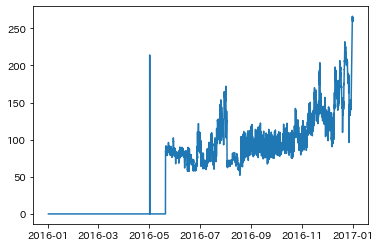

In [56]:
plt.plot(data_merge[(data_merge["meter"]==0) & (data_merge["building_id"]==0) ]["timestamp"],data_merge[(data_merge["meter"]==0) & (data_merge["building_id"]==6)]["meter_reading"])

In [57]:
data_merge.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
103,105,0,2016-01-01 00:00:00,23.3036,1,Education,50623,NaN,5.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1
104,106,0,2016-01-01 00:00:00,0.3746,1,Education,5374,NaN,4.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1
105,106,3,2016-01-01 00:00:00,0.0000,1,Education,5374,NaN,4.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1
106,107,0,2016-01-01 00:00:00,175.1840,1,Education,97532,2005.0,10.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1
107,108,0,2016-01-01 00:00:00,91.2653,1,Education,81580,1913.0,5.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.7500,15,Entertainment/public assembly,19619,1914.0,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8
20216096,1445,0,2016-12-31 23:00:00,4.8250,15,Education,4298,NaN,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8
20216097,1446,0,2016-12-31 23:00:00,0.0000,15,Entertainment/public assembly,11265,1997.0,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8
20216098,1447,0,2016-12-31 23:00:00,159.5750,15,Lodging/residential,29775,2001.0,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8


In [58]:
##

In [44]:
data_merge[data_merge["building_id"]==0].mean()

c:\users\komori\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


building_id              0.000000
meter                    0.000000
meter_reading          146.454978
site_id                  0.000000
square_feet           7432.000000
year_built            2008.000000
floor_count                   NaN
air_temperature         22.836021
cloud_coverage           3.044610
dew_temperature         16.817880
precip_depth_1_hr        1.382557
sea_level_pressure    1017.988378
wind_direction         156.494024
wind_speed               3.375114
dtype: float64

In [43]:
building_mean = df_group.mean().astype(np.float16)


c:\users\komori\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


building_id              0.000000
meter                    0.000000
meter_reading          146.454978
site_id                  0.000000
square_feet           7432.000000
year_built            2008.000000
floor_count                   NaN
air_temperature         22.836021
cloud_coverage           3.044610
dew_temperature         16.817880
precip_depth_1_hr        1.382557
sea_level_pressure    1017.988378
wind_direction         156.494024
wind_speed               3.375114
dtype: float64

In [68]:
### これらの情報をテストデータにも付与

In [60]:
df_group =data_merge.groupby('building_id')['meter_reading']

In [64]:
building_mean = df_group.mean().astype(np.float16)
building_median = df_group.median().astype(np.float16)
building_min = df_group.min().astype(np.float16)
building_max = df_group.max().astype(np.float16)
building_std = df_group.std().astype(np.float16)

In [66]:
building_mean

building_id
0       146.500000
1        74.875000
2        14.554688
3       235.500000
4       976.500000
           ...    
1444      7.480469
1445      4.734375
1446      3.591797
1447    187.125000
1448      3.337891
Name: meter_reading, Length: 1449, dtype: float16

In [67]:
building_max

building_id
0        448.000000
1        255.000000
2         68.000000
3        937.000000
4       3592.000000
           ...     
1444      35.812500
1445      10.851562
1446      15.296875
1447     259.000000
1448       6.648438
Name: meter_reading, Length: 1449, dtype: float16

In [69]:
data_merge['building_mean'] = data_merge['building_id'].map(building_mean)
data_merge['building_median'] = data_merge['building_id'].map(building_median)
data_merge['building_min'] = data_merge['building_id'].map(building_min)
data_merge['building_max'] = data_merge['building_id'].map(building_max)
data_merge['building_std'] = data_merge['building_id'].map(building_std)

### データ前処理のテクニック
- #### primary_useに関しては番号を振っている

In [74]:
primary_use_list = building_metadata['primary_use'].unique()
primary_use_dict = {key: value for value, key in enumerate(primary_use_list)} 
print('primary_use_dict: ', primary_use_dict)

primary_use_dict:  {'Education': 0, 'Lodging/residential': 1, 'Office': 2, 'Entertainment/public assembly': 3, 'Other': 4, 'Retail': 5, 'Parking': 6, 'Public services': 7, 'Warehouse/storage': 8, 'Food sales and service': 9, 'Religious worship': 10, 'Healthcare': 11, 'Utility': 12, 'Technology/science': 13, 'Manufacturing/industrial': 14, 'Services': 15}
